# Exercise session 6 for the course "Declarative Problem Solving Paradigms in AI"

In this session we will work on symmetry and dominance breaking

In [1]:
# Setup
# !pip install --upgrade cpmpy --quiet
# !pip install matplotlib --quiet

import cpmpy as cp
import numpy as np
import matplotlib.pyplot as plt

## Exercise 1: grocery store prices
A kid goes into a grocery store and buys four items. The cashier charges €7.11,
the kid pays and is about to leave when the cashier calls the kid back, and says
"Hold on, I multiplied the four items instead of adding them; I'll try again; Hah,
with adding them the price still comes to €7.11". What were the prices of the
four items?
Write a model that solves the problem. Use solveAll to find all the solutions

Hint: CPMpy does not work well with floating point numbers, think about how to convert them to integers

In [2]:
a, b, c, d = cp.intvar(0, 711, shape=4, name=list("abcd"))

model = cp.Model(
    a + b + c + d == int(7.11 * 100),
    a * b * c * d == int(7.11 * 100**4),
)

model.solveAll(display=[a, b, c, d])

[125, 120, 316, 150]
[125, 120, 150, 316]
[150, 120, 316, 125]
[316, 120, 150, 125]
[316, 120, 125, 150]
[150, 120, 125, 316]
[150, 125, 120, 316]
[150, 316, 120, 125]
[150, 316, 125, 120]
[150, 125, 316, 120]
[120, 125, 316, 150]
[120, 150, 316, 125]
[120, 125, 150, 316]
[316, 125, 150, 120]
[125, 316, 150, 120]
[120, 316, 150, 125]
[120, 316, 125, 150]
[120, 150, 125, 316]
[316, 150, 125, 120]
[316, 150, 120, 125]
[125, 150, 120, 316]
[125, 316, 120, 150]
[316, 125, 120, 150]
[125, 150, 316, 120]


24

Now think about the possible symmetric solutions and add the corresponding constraints to exclude them from the satisfying assignments.
Find all solutions to check that there are no symmetric solutions among the possible ones.
What kind of symmetries are present in this problem, is it a problem, instance or model symmetry?
Value or variables symmetry?

This is a variable symmetry, any of the variables can swap places with each other.
The symmetry is inherent to the problem, so it's a problem symmetry.

In [3]:
# break variable problem symmetry by ordering the variables
model += cp.Increasing([a, b, c, d])

model.solveAll(display=[a,b,c,d])

[120, 125, 150, 316]


1

## Exercise 2
We want to climb a stair of n steps: we can move up one step at a time or take
two steps at a time (you can generalize to m steps at a time).

We are interested in the possible combinations of steps taken each time to get to the top of the staircase.
For example, a stair of 4 steps with m=2 can be climbed with a sequence of
four one-step moves or with two two-step moves.

Define a model that
finds all the possible combinations of moves of size 1, 2 up to m to climb a staircase
of size n.
For n=4 and m=2 the solutions without symmetries for example are:
1111
112
121
211
22


In [4]:
n = 4
m = 2

steps = cp.intvar(0, m, shape=n, name="steps")

model = cp.Model(
    cp.sum(steps) == n,
)

model.solveAll(display=steps)

[0 0 2 2]
[0 1 1 2]
[0 2 0 2]
[0 2 1 1]
[0 2 2 0]
[0 1 2 1]
[1 1 2 0]
[1 0 2 1]
[2 0 2 0]
[2 0 1 1]
[2 1 1 0]
[1 1 1 1]
[1 0 1 2]
[1 2 1 0]
[1 2 0 1]
[1 1 0 2]
[2 1 0 1]
[2 2 0 0]
[2 0 0 2]


19

Think about all the possible symmetric solutions
Is it a problem, instance or model symmetry? Value or variables symmetry?
Add constraints that break these symmetries.
Make sure to set the solver to find all solutions in order to verify that your model does not lead to symmetric solutions.

Because we care about the order we take our steps (112 and 211 are not considered symmetric), there is no variable symmetry here. The symmetry is on the value 0, that can be in any place in our list without changing the solutions.

Even though it's hard to find another viewpoint, we still consider this a model symmetry. Further down we give an example of a different viewpoint.

In [5]:
# add symmetry breaking, put 0's last
model += [(steps[i] == 0).implies(steps[i + 1] == 0) for i in range(n - 1)]

model.solveAll(display=steps)

[2 1 1 0]
[2 2 0 0]
[1 2 1 0]
[1 1 2 0]
[1 1 1 1]


5

Assume now that we do not care for the order of the sequence of steps: Thus 112 and 121 would be symmetric solutions. Can we break these symmetries by reformulation?


Since we don't care about the ordering of our steps anymore there would have been variable symmetry when using a variable for each step we take.
However that would have been a model symmetry, since we can come up with a different viewpoint without symmetries, as shown below.
Here we just look at how many times we take each step size.

In [6]:
# model symmetry is better solved by assuming a different viewpoint
n = 4
m = 2

steps = cp.intvar(0, n, shape=m, name="steps")

model = cp.Model(
    sum([steps[i] * (i+1) for i in range(m)]) == n,
)

model.solveAll(display=steps)

[4 0]
[2 1]
[0 2]


3

If we again consider the previous case where the order is important, we got symmetries on the location of '0''s in our steps variable.
You can argue this is a problem symmetry, since the problem specification includes this ambiguity on the number of moves you need to take.
There is however another viewpoint you can take to avoid this symmetry:

In [7]:
n = 4
m = 2

steps = cp.boolvar(shape=n, name="steps") # boolean variables that indicate if we stepped on step i when climbing the staircase

model = cp.Model(
    steps[-1], # must reach the top
    [sum(steps[i:i+m]) >= 1 for i in range(n-m+1)], # at least one step in each window of m steps
)

model.solveAll(display=steps)

[ True  True False  True]
[ True  True  True  True]
[ True False  True  True]
[False  True  True  True]
[False  True False  True]


5

## Exercise 3
We revisit the RCPSP problem from exercise session 3, with a few changes.

A number of activities are to be scheduled.
- Each activity has a duration and cannot be interrupted.
- There are no precedence relations between activities.
- There are 2 renewable resources, each with a maximum capacity of 1, ensuring no more than 1 unit of each resource can be in use at any given time slot.
- Each activity has a demand on each resource.

Minimize the starting time of the last activity.

What (types of) symmetries do you see?
Is there any dominance breaking possible?


In [8]:
# Data, there are 12 tasks to be scheduled, with 2 resources that can be used.
# Task durations
durations = cp.cpm_array([3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5])
# resources needed by the tasks
resource_needs = cp.cpm_array([[1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0]])
# Total resource capacity for each of the two resources
resource_capacities = cp.cpm_array([1, 1])

nb_resource = len(resource_capacities)
nb_jobs = len(durations)
max_duration = sum(durations)  # dummy upper bound, can be improved of course

# Variables, we need to find a list of starting times that satisfies all the constraints.
start_time = cp.intvar(0, max_duration, shape=nb_jobs)

model = cp.Model()

# Add resource usage constraints for the two resources
for resource in range(2):
    model += cp.Cumulative(
        start=start_time,
        duration=durations,
        end=start_time + durations,
        demand=resource_needs[:, resource],
        capacity=resource_capacities[resource],
    )


# break the (instance) symmetries
model += cp.IncreasingStrict(start_time[0:4])
model += cp.IncreasingStrict(start_time[4:8])
model += cp.IncreasingStrict(start_time[8:12])
#model += start_time[3] < start_time[8]

# dominance: last task will be the longest task
model += start_time[3] < start_time[11]

# or replace our first symmetry breaking constraint with this one:
#model += cp.IncreasingStrict(np.concatenate((start_time[0:4], [start_time[11]])))


# minimize total execution time
model.minimize(cp.Maximum(start_time))


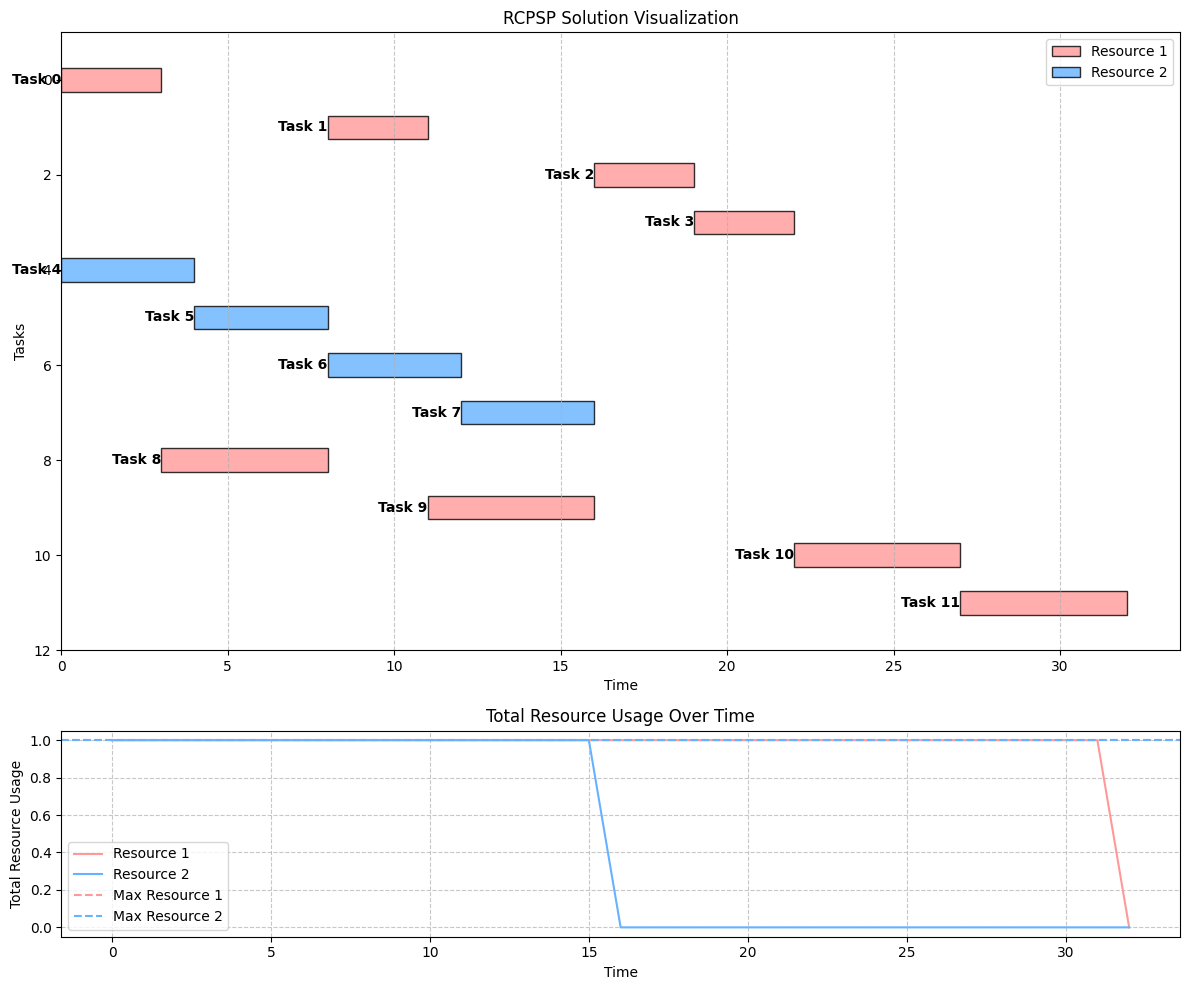

Makespan: 32


In [9]:
# Visualize the RCPSP solution

model.solve()
# Get the solution values
start_times = start_time.value()
end_times = start_times + np.array(durations)

# Create a figure and axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1]})

# Define colors for each resource
colors = ['#FF9999', '#66B2FF']

# Plot each task as a horizontal bar
for resource in range(nb_jobs):
    if durations[resource] > 0:  # Skip tasks with zero duration
        ax1.barh(resource, durations[resource], left=start_times[resource], height=0.5,
                 color=colors[np.argmax(resource_needs[resource])],
                 alpha=0.8, edgecolor='black')

        # Add task labels
        ax1.text(start_times[resource], resource, f'Task {resource}', va='center', ha='right', fontweight='bold')

# Customize the task plot
ax1.set_xlabel('Time')
ax1.set_ylabel('Tasks')
ax1.set_title('RCPSP Solution Visualization')
ax1.set_ylim(-1, nb_jobs)
ax1.invert_yaxis()  # Invert y-axis to have task 0 at the top

# Add a legend for tasks
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors[i], edgecolor='black', alpha=0.8, label=f'Resource {i+1}') for i in range(nb_resource)]
ax1.legend(handles=legend_elements, loc='upper right')

# Show the grid for tasks
ax1.grid(True, axis='x', linestyle='--', alpha=0.7)

# Calculate total resource usage over time
max_time = max(end_times)
resource_usage = np.zeros((nb_resource, max_time + 1))
for resource in range(nb_jobs):
    for t in range(start_times[resource], end_times[resource]):
        for r in range(nb_resource):
            resource_usage[r, t] += resource_needs[resource, r]

# Plot total resource usage
for r in range(nb_resource):
    ax2.plot(range(max_time + 1), resource_usage[r], label=f'Resource {r+1}', color=colors[r])

# Plot maximal allowed usage
for r in range(nb_resource):
    ax2.axhline(y=resource_capacities[r], color=colors[r], linestyle='--',
                label=f'Max Resource {r+1}')

ax2.set_xlabel('Time')
ax2.set_ylabel('Total Resource Usage')
ax2.set_title('Total Resource Usage Over Time')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print the makespan (total project duration)
print(f"Makespan: {max(end_times)}")


## Exercise 4
A heterosquare of order n is a n*n square whose elements are distinct integers from
1 to n^2 such that the sums of the rows, columns and diagonals are all different.
Here is an example of heterosquare of order 3
```
           19

1  2  3    6
8  9  4    21
7  6  5    18

16 17 12   15  (Sums)
```
Write a CPMpy Model to solve a heterosquare of order n, and think about the symmetries in its solutions.
hint: without symmetry breaking there are 24960 solutions, with symmetry breaking 3120.

In [10]:
n = 3

square = cp.intvar(1, n*n, shape=(n,n))
model = cp.Model()

cols = [square[:,i] for i in range(n)]
rows = [square[i] for i in range(n)]
diagonals = [square.diagonal(), np.fliplr(square).diagonal()]

allsums = [sum(x) for x in cols + rows + diagonals]
model += cp.AllDifferent(allsums)
model += cp.AllDifferent(square)


# symmetry breaking
model += (square[0,0] <= square[0,n-1])
model += (square[0,0] <= square[n-1,0])
model += (square[0,0] <= square[n-1,n-1])
model += (square[0,1] <= square[1,0])


def display_solution():
    print("Heterosquare:")
    for i in range(n):
        row = square[i].value()
        print(f"Row {i+1}: {' '.join(map(str, row))} (sum: {sum(row)})")
    print()
    for i in range(n):
        col = square[:,i].value()
        print(f"Column {i+1} sum: {sum(col)}")
    print(f"Diagonal sum: {sum(square.diagonal().value())}")
    print(f"Anti-diagonal sum: {sum(np.fliplr(square).diagonal().value())}")


model.solveAll()

3120

It's important here to find out in what way the problem is symmetric. Careful consideration show that solutions are symmetric when we mirror the square around the center row, center column, and one of the 2 diagonals. Solutions are also symmetric under rotation of the whole matrix, but this can be expressed by doing both row and diagonal mirroring.

Each of our symmetry breaking constraints is dealing with one of our symmetries (put an ordering on 2 symmetric solutions, such that only one remains).

## Exercise 5
Balanced Incomplete Block Design (BIBD)

A BIBD is defined as an arrangement of $v$ distinct objects into b blocks such that

- each block contains exactly $k$ distinct objects,
- each object occurs in exactly $r$ different blocks, and
- every two distinct objects occur together in exactly $l$ blocks.

Another way of defining a BIBD is in terms of its incidence matrix, which is a $v$ by $b$ binary matrix with exactly $r$ ones per row, $k$ ones per column, and with a scalar product of $l$ between any pair of distinct rows.

Write a CPMpy Model to solve a BIBD and solve the problem with the following data:

In [11]:
# Data
v,b = 7,7
r,k = 3,3
l = 1

Find all solutions of the problem. (don't print all solutions; it has too many)


In [12]:
# Variables, incidence matrix
block = cp.boolvar(shape=(v,b), name="block")

# Constraints on incidence matrix
m = cp.Model(
        [cp.sum(row) == r for row in block],
        [cp.sum(col) == k for col in block.T],
)

# The scalar product of every pair of distinct rows sums up to `l`
for row_a in range(v):
    for row_b in range(row_a+1,v):
        m += cp.sum(block[row_a,:] * block[row_b,:]) == l


def print_solution():
    print(f"BIBD: {b} obj, {v} blocks, r={r}, k={k}, l={l}")
    for (i, row) in enumerate(block.value()):
        srow = "".join('X ' if e else '  ' for e in row)
        print(f"Object {i + 1}: [ {srow}]")


sols_num = m.solveAll(display=print_solution, solution_limit=5)
print(sols_num)

BIBD: 7 obj, 7 blocks, r=3, k=3, l=1
Object 1: [       X X   X ]
Object 2: [     X     X X ]
Object 3: [   X     X X   ]
Object 4: [   X X X       ]
Object 5: [ X     X   X   ]
Object 6: [ X   X   X     ]
Object 7: [ X X         X ]
BIBD: 7 obj, 7 blocks, r=3, k=3, l=1
Object 1: [     X     X X ]
Object 2: [       X X   X ]
Object 3: [   X     X X   ]
Object 4: [   X X X       ]
Object 5: [ X     X   X   ]
Object 6: [ X   X   X     ]
Object 7: [ X X         X ]
BIBD: 7 obj, 7 blocks, r=3, k=3, l=1
Object 1: [     X     X X ]
Object 2: [       X X X   ]
Object 3: [   X     X   X ]
Object 4: [   X X X       ]
Object 5: [ X     X     X ]
Object 6: [ X   X   X     ]
Object 7: [ X X       X   ]
BIBD: 7 obj, 7 blocks, r=3, k=3, l=1
Object 1: [       X X X   ]
Object 2: [     X     X X ]
Object 3: [   X     X   X ]
Object 4: [   X X X       ]
Object 5: [ X     X     X ]
Object 6: [ X   X   X     ]
Object 7: [ X X       X   ]
BIBD: 7 obj, 7 blocks, r=3, k=3, l=1
Object 1: [ X         X X ]
Obj

Print a few solutions and try to detect symmetric solutions. Does this problem have any symmetries? If yes, what type of symmetries? Break the symmetries and notice the reduction in the number of solutions.


There are both row and column symmetries here, we can swap any 2 rows, and any 2 columns.

In [13]:
# Variables, incidence matrix
block = cp.boolvar(shape=(v,b), name="block")

# Constraints on incidence matrix
m = cp.Model(
    [cp.sum(row) == r for row in block],
    [cp.sum(col) == k for col in block.T],
)

# the scalar product of every pair of distinct rows sums up to `l`
for row_a in range(v):
    for row_b in range(row_a+1,v):
        m += cp.sum(block[row_a,:] * block[row_b,:]) == l
        m += cp.LexLess(block[row_a,:],block[row_b,:])

m += cp.LexChainLess(block)
for col_a in range(b):
    for col_b in range(col_a + 1, b):
        m += cp.LexLess(block.T[col_a], block.T[col_b])

# symmetry breaking by rows and columns; the LexChainLess is an alternative to putting lexless inside the loop
# m += cp.LexChainLess(block)
# m += cp.LexChainLess(block.T) # this is currently bugged however, until release of CPMpy 0.9.24

sols_num = m.solveAll(display=print_solution)
print(sols_num)

BIBD: 7 obj, 7 blocks, r=3, k=3, l=1
Object 1: [         X X X ]
Object 2: [     X X     X ]
Object 3: [   X   X   X   ]
Object 4: [   X X   X     ]
Object 5: [ X     X X     ]
Object 6: [ X   X     X   ]
Object 7: [ X X         X ]
1
